# Task 5 — Model Training & Tracking

**Objective:** Train, tune, track, and register credit-risk classification models using MLflow.
This notebook documents the training workflow, shows how experiments are logged to MLflow, and demonstrates how to load and evaluate the best model. Follow sections in order.

## 1) Setup

This section installs (if required) and imports dependencies, sets up the local MLflow tracking folder, and exposes repository modules on the Python path. The repository already includes `src/train.py` which implements training, tuning, and MLflow logging.

In [7]:
# Standard imports for analysis and plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('whitegrid')

In [8]:
# Configure project path and MLflow tracking to local `mlruns` directory
from pathlib import Path
import os
import sys
import mlflow
from mlflow import MlflowClient

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

LOCAL_MLFLOW = (PROJECT_ROOT / 'mlruns').resolve()
tracking_uri = f"file:///{LOCAL_MLFLOW.as_posix()}"
EXPERIMENT_NAME = 'credit-risk-model'

os.environ['MLFLOW_TRACKING_URI'] = tracking_uri
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(EXPERIMENT_NAME)
print('MLFLOW_TRACKING_URI ->', tracking_uri)
print('MLFLOW_EXPERIMENT ->', EXPERIMENT_NAME)

# Import helper entrypoints from the repository
from src.data_processing import run_data_processing_pipeline
from src.train import main as train_main

# Run data processing to produce `processed` artifacts used by training
processed_dataset = run_data_processing_pipeline()
print('Processed features shape:', processed_dataset.customer_features.shape)

# Note: training is performed in the next cell so you can inspect data first

MLFLOW_TRACKING_URI -> file:///C:/Users/alexo/Desktop/File/10Academy/week4/Github/Credit-Risk-Probability-Model-for-Alternative-Data/mlruns
MLFLOW_EXPERIMENT -> credit-risk-model


INFO:src.data_processing:Loaded 95662 rows from data.csv
INFO:src.data_processing:Initialized end-to-end processing pipeline
INFO:src.data_processing:Created temporal features
INFO:src.data_processing:Calculated RFM metrics for 3742 customers
INFO:src.data_processing:Identified high-risk cluster 2 covering 0.11% of customers
INFO:src.data_processing:Split dataset: train=(2993, 26), test=(749, 26)
INFO:src.data_processing:Artifacts saved to C:\Users\alexo\Desktop\File\10Academy\week4\Github\Credit-Risk-Probability-Model-for-Alternative-Data\data\processed


Processed features shape: (3742, 28)


## 2) Model Selection & Training

We train at least two models (Logistic Regression and Random Forest) using `src.train.train_and_track_models`. The training code performs hyperparameter tuning (grid search for logistic, randomized search for random forest), logs parameters/metrics/artifacts to MLflow, and registers the best model in the MLflow Model Registry.

In [9]:
# Run the training pipeline (this will create MLflow runs in ./mlruns)
# It will train multiple models, tune hyperparameters, log metrics and artifacts, and register the best model.
train_main()
print('Training complete. Check the mlruns/ directory or open the MLflow UI to compare runs.')

INFO:src.train:Loading processed training artifacts...
INFO:src.train:Feature matrix ready with 26 columns
INFO:src.train:
INFO:src.train:Training Logistic Regression
INFO:src.train:==================================================
INFO:src.train:Starting Grid Search for Logistic Regression
c:\Users\alexo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\alexo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' 

Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\alexo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\alexo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\alexo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was depr

Fitting 3 folds for each of 20 candidates, totalling 60 fits


INFO:src.train:Best CV Score: 1.0000
INFO:src.train:Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 15}
INFO:src.train:Evaluation Results: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}
2025/12/15 10:52:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/15 10:52:06 WARNING mlflow.utils.requirements_utils: Encountered an unexpected error (TypeError("'NoneType' object is not subscriptable")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.
c:\Users\alexo\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\tracking\_model_registry\utils.py:215: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See 

Training complete. Check the mlruns/ directory or open the MLflow UI to compare runs.


## 3) Inspect Recent MLflow Runs

This section queries the local MLflow tracking store for finished runs, extracts key metrics and parameters, and presents a short table for comparison. Use the MLflow UI (`mlflow ui --backend-store-uri file://./mlruns`) to get a richer view.

In [10]:
client = MlflowClient(tracking_uri=tracking_uri)
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    raise RuntimeError(f"No MLflow experiment named {EXPERIMENT_NAME} at {tracking_uri}")

runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="attributes.status = 'FINISHED'",
    order_by=["metrics.roc_auc DESC"],
    max_results=10,
)
metrics_table = []
for run in runs:
    metrics_table.append({
        'run_id': run.info.run_id,
        'model': run.data.params.get('model_type', 'unknown'),
        'accuracy': run.data.metrics.get('accuracy'),
        'precision': run.data.metrics.get('precision'),
        'recall': run.data.metrics.get('recall'),
        'f1': run.data.metrics.get('f1'),
        'roc_auc': run.data.metrics.get('roc_auc'),
        'started_at': pd.to_datetime(run.info.start_time, unit='ms'),
    })
if not metrics_table:
    print('No completed MLflow runs available yet. Re-run the training cell above first.')
else:
    metrics_df = pd.DataFrame(metrics_table)
    metric_cols = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    metrics_df[metric_cols] = metrics_df[metric_cols].apply(pd.to_numeric, errors='coerce')
    display(metrics_df.sort_values('roc_auc', ascending=False).head(10))

,run_id,model,accuracy,precision,recall,f1,roc_auc,started_at
0,d3e2aaf906304cb6920e590a85894182,Random Forest,1.0,1.0,1.0,1.0,1.0,2025-12-15 05:21:50.023
1,12c754944f174bad82a4869cb268b3e4,Logistic Regression,1.0,1.0,1.0,1.0,1.0,2025-12-15 05:21:49.310
2,4bf9f9e3ff3e4aae955b54c4f01d4350,Random Forest,1.0,1.0,1.0,1.0,1.0,2025-12-15 05:16:18.294
3,b158162581714da9bbbbbec216b30fe1,Logistic Regression,1.0,1.0,1.0,1.0,1.0,2025-12-15 05:16:07.579
4,f3c30661298a4294b22c43a5c13d65dd,Random Forest,1.0,1.0,1.0,1.0,1.0,2025-12-14 08:14:51.528
5,da14b3a23ab54d3eb0ed2175867329b0,Logistic Regression,1.0,1.0,1.0,1.0,1.0,2025-12-14 08:14:45.714
6,a5a897bbdb9b4fcd8f8400cf03febd3e,Random Forest,1.0,1.0,1.0,1.0,1.0,2025-12-14 08:14:16.710
7,0c1a3d5a697b445db475c965b7e68a5a,Logistic Regression,1.0,1.0,1.0,1.0,1.0,2025-12-14 08:14:10.592
8,c7cf78a95ec642a6ac629d4e2ba07494,Random Forest,1.0,1.0,1.0,1.0,1.0,2025-12-14 08:13:43.667
9,82660f4a084a4fe58413288a3c730293,Logistic Regression,1.0,1.0,1.0,1.0,1.0,2025-12-14 08:13:37.788


## 4) Load Best Model & Evaluate on Test Set

Load the best model artifact from the best MLflow run, compute test-set metrics (accuracy, precision, recall, f1, ROC-AUC), and produce a confusion matrix and summary table.

c:\Users\alexo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best run: Random Forest (d3e2aaf906304cb6920e590a85894182) | ROC-AUC=1.000


C:\Users\alexo\AppData\Local\Temp\ipykernel_14552\762846934.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_cols, y=best_metrics.values, palette='crest', ax=axes[1])


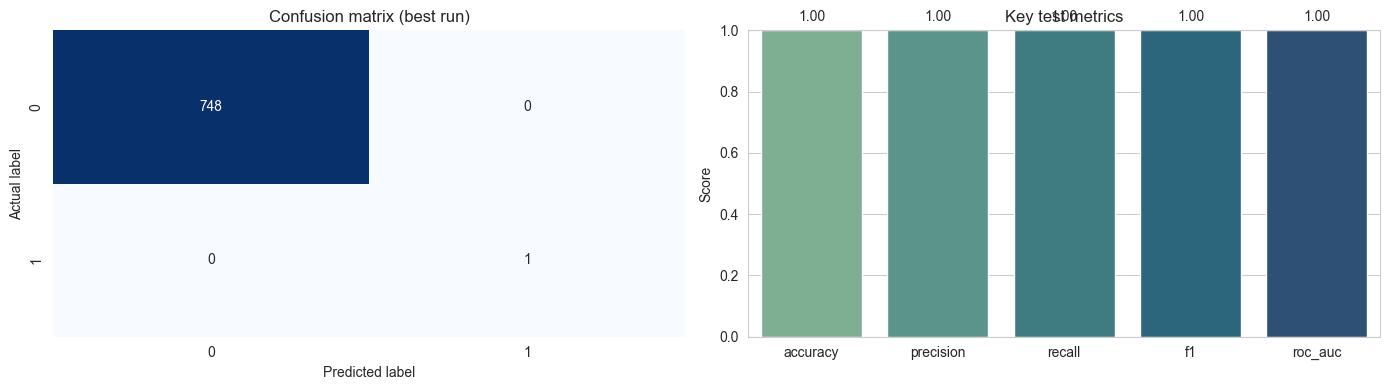

,precision,recall,f1-score,support
0,1.00,1.00,1.00,748
1,1.00,1.00,1.00,1
macro avg,1.00,1.00,1.00,749
weighted avg,1.00,1.00,1.00,749


In [11]:
import mlflow.sklearn
# Ensure we have runs to inspect
if 'metrics_df' not in globals() or metrics_df.empty:
    raise RuntimeError('Run the cell first to populate metrics_df.')
if 'processed_dataset' not in globals():
    raise RuntimeError('Run the Setup cell to materialize processed_dataset.')

# Identify top run by ROC-AUC
best_run = metrics_df.sort_values('roc_auc', ascending=False).iloc[0]
artifact_subpath = best_run['model'].lower().replace(' ', '_')
model_uri = f"runs:/{best_run['run_id']}/{artifact_subpath}"
best_model = mlflow.sklearn.load_model(model_uri)

X_eval = processed_dataset.X_test
y_eval = processed_dataset.y_test
y_pred = best_model.predict(X_eval)
y_prob = best_model.predict_proba(X_eval)[:, 1]

# Metrics and confusion matrix
cm = confusion_matrix(y_eval, y_pred)
report_df = pd.DataFrame(
    classification_report(y_eval, y_pred, output_dict=True, zero_division=0)
).T[['precision', 'recall', 'f1-score', 'support']]
ordered_index = [idx for idx in ['0', '1', 'macro avg', 'weighted avg'] if idx in report_df.index]
report_df = report_df.loc[ordered_index]

metric_cols = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
best_metrics = best_run[metric_cols].astype(float).fillna(0)

print(f"Best run: {best_run['model']} ({best_run['run_id']}) | ROC-AUC={best_run['roc_auc']:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('Actual label')
axes[0].set_title('Confusion matrix (best run)')

sns.barplot(x=metric_cols, y=best_metrics.values, palette='crest', ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title('Key test metrics')
axes[1].set_ylabel('Score')
for idx, value in enumerate(best_metrics.values):
    axes[1].text(idx, min(value + 0.02, 1.02), f"{value:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

report_df.style.format({'precision': '{:.2f}', 'recall': '{:.2f}', 'f1-score': '{:.2f}', 'support': '{:.0f}'})